In [65]:
from astropy.io import fits
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import numpy as np

In [79]:
file_name_1 = 'bundle_20230529_standards/spectrum_20230112_0000009_exp01_orange.fits'
hdul_1 = fits.open(file_name_1)
data_1 = hdul[0].data
hdr_1 = hdul[0].header

file_name_2 = 'bundle_20230529_standards/spectrum_20230112_0000009_exp01_uv.fits'
hdul_2 = fits.open(file_name_2)
data_2 = hdul[0].data
hdr_2 = hdul[0].header


[4.63500000e+03 4.63612215e+03 4.63724430e+03 ... 9.84891604e-11
 9.84964564e-11 9.85067903e-11]


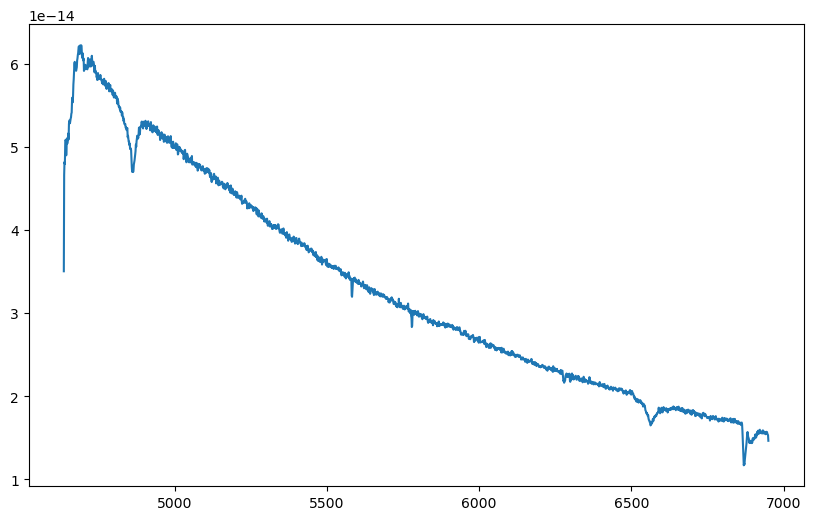

In [80]:
print(data)

plt.figure(figsize=(10, 6))
wl = data_2[0]
flux = data_2[1]




plt.plot(wl, flux)
#plt.xlim(6000, 7000)
plt.show()

In [38]:
print(max(wl))

6950.0
